In [1]:
import os
import torch
import numpy as np
import tempfile
from contextlib import nullcontext

from mast3r.demo import get_args_parser, main_demo, get_reconstructed_scene, set_scenegraph_options
from dust3r.utils.device import to_numpy

from mast3r.cloud_opt.sparse_ga import sparse_global_alignment

from mast3r.model import AsymmetricMASt3R
from mast3r.utils.misc import hash_md5

import mast3r.utils.path_to_dust3r  # noqa
from dust3r.demo import set_print_with_timestamp

import matplotlib.pyplot as pl

import os
from scipy.io import savemat
import argparse

%load_ext autoreload
%autoreload 2

/home/manuelf/mast3r/dust3r/dust3r/cloud_opt/base_opt.py:276: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [7]:
from dust3r.utils.image import load_images
import copy

outdir = "./output"
device = "cuda:1"
#device = "cpu"
#im_dir = "./images_in/pda"
im_dir = "./images_in/train"

#make filelist be a list of all the files in the directory
#filelist = [os.path.join(filelist, f) for f in os.listdir(filelist)]
#print(filelist)

#load images

imgs = load_images(im_dir, size=512, verbose=1, skip_frames=4)
filelist = [img["path"] for img in imgs]

if len(imgs) == 1:
        imgs = [imgs[0], copy.deepcopy(imgs[0])]
        imgs[1]['idx'] = 1
        filelist = [im_dir[0], im_dir[0] + '_2']
        

imgs[0].keys()

>> Loading images from ./images_in/train
 - adding 00000.jpg with resolution 854x480 --> 512x288
 - adding 00005.jpg with resolution 854x480 --> 512x288
 - adding 00010.jpg with resolution 854x480 --> 512x288
 - adding 00015.jpg with resolution 854x480 --> 512x288
 - adding 00020.jpg with resolution 854x480 --> 512x288
 - adding 00025.jpg with resolution 854x480 --> 512x288
 - adding 00030.jpg with resolution 854x480 --> 512x288
 - adding 00035.jpg with resolution 854x480 --> 512x288
 - adding 00040.jpg with resolution 854x480 --> 512x288
 - adding 00045.jpg with resolution 854x480 --> 512x288
 - adding 00050.jpg with resolution 854x480 --> 512x288
 - adding 00055.jpg with resolution 854x480 --> 512x288
 - adding 00060.jpg with resolution 854x480 --> 512x288
 - adding 00065.jpg with resolution 854x480 --> 512x288
 - adding 00070.jpg with resolution 854x480 --> 512x288
 - adding 00075.jpg with resolution 854x480 --> 512x288
 (Found 16 images)


dict_keys(['img', 'true_shape', 'idx', 'instance', 'path'])

In [4]:
model = AsymmetricMASt3R.from_pretrained("./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth").to(device)

... loading model from ./docker/files/checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth


/home/manuelf/mast3r/mast3r/model.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path, map_location='cpu')


instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>


len of pairs 58


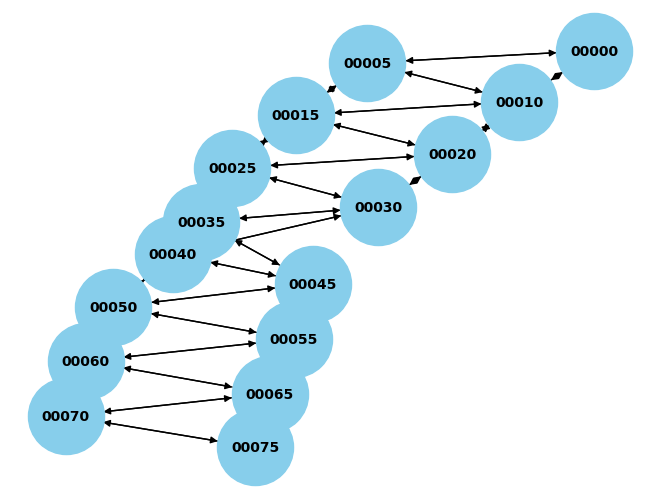

In [63]:
#test make_pairs
from dust3r.image_pairs import make_pairs
from auxiliar.viz_graph import viz_graph

#scenegraphy
scenegraph_type="swin"
win_cyclic = False
winsize = 2
refid = 0

scene_graph_params = [scenegraph_type]
if scenegraph_type in ["swin", "logwin"]:
    scene_graph_params.append(str(winsize))
elif scenegraph_type == "oneref":
    scene_graph_params.append(str(refid))
if scenegraph_type in ["swin", "logwin"] and not win_cyclic:
    scene_graph_params.append('noncyclic')
scene_graph = '-'.join(scene_graph_params)

pairs = make_pairs(imgs, scene_graph=scene_graph, prefilter=None, symmetrize=True)

print("len of pairs", len(pairs))

file_names = [im["path"] for im in imgs]

viz_graph(file_names, pairs)

In [11]:
from auxiliar.scene_to_data import SceneToData
import time

# cache to store previous inference results
delete_cache = True
if delete_cache:
    os.system(f"rm -rf {outdir}/cache")
cache_dir = os.path.join(outdir, 'cache')
os.makedirs(cache_dir, exist_ok=True)

# optimization level
optim_level = "coarse"
niter2 = 0 if optim_level == "coarse" else 200

scene, _, res_coarse, res_fine = sparse_global_alignment(filelist, pairs, cache_dir,
                                    model, lr1=0.07 , niter1=500, lr2=0.014, niter2=niter2, device=device,
                                    opt_depth='depth' in optim_level, shared_intrinsics=False,
                                    matching_conf_thr=0.5)

#save the scene into mat files and full pcd file with 0wrld pts
scene_class = SceneToData(scene)
scene_class.save_mat_file(outdir)
scene_class.save_pcd_file(outdir, conf_threshold=0.001)



100%|████████████████████████| 72/72 [00:20<00:00,  3.54it/s]


Inference time: 7.79s, Correspondences time: 11.37s


100%|█████████████████████████████████████████| 9/9 [00:00<00:00, 12.04it/s]


init focals = [360.00278 366.87067 370.14722 368.44513 367.51724 362.32373 362.1396
 366.45538 378.14618]


100%|██████████████| 500/500 [00:20<00:00, 24.35it/s, lr=0.0000, loss=0.165]


>> final loss = 0.1647568643093109
Final focals = [360.00278 366.87067 370.14722 368.44513 367.51724 362.32373 362.1396
 366.45538 378.14618]
Optimization took 20.54051160812378 s


In [30]:
# dust3r ga + mast3r model
from dust3r.inference import inference
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

output = inference(pairs, model, device, batch_size=10, verbose=True)

mode = GlobalAlignerMode.PointCloudOptimizer if len(imgs) > 2 else GlobalAlignerMode.PairViewer
scene = global_aligner(output, device=device, mode=mode, verbose=True)



>> Inference with model on 58 image pairs


  0%|                                                                                                           | 0/6 [00:00<?, ?it/s]/home/manuelf/mast3r/dust3r/dust3r/inference.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/manuelf/mast3r/dust3r/dust3r/model.py:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/manuelf/mast3r/dust3r/dust3r/inference.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/it]


In [ ]:
loss = scene.compute_global_alignment(init='mst', niter=500, schedule="cosine", lr=0.01)

 init edge (9*,11*) score=np.float64(10.380651473999023)
 init edge (11,13*) score=np.float64(6.874716758728027)
 init edge (9,7*) score=np.float64(3.985013723373413)
 init edge (7,8*) score=np.float64(3.881218671798706)
 init edge (6*,8) score=np.float64(3.6207964420318604)
 init edge (4*,6) score=np.float64(3.3150012493133545)
 init edge (3*,4) score=np.float64(2.7533679008483887)
 init edge (15*,13) score=np.float64(8.506359100341797)
 init edge (8,10*) score=np.float64(8.278099060058594)
 init edge (10,12*) score=np.float64(8.260712623596191)
 init edge (12,14*) score=np.float64(7.617799282073975)
 init edge (1*,3) score=np.float64(5.592435836791992)
 init edge (5*,3) score=np.float64(3.3116137981414795)
 init edge (0*,1) score=np.float64(2.9579827785491943)
 init edge (0,2*) score=np.float64(3.3949220180511475)
 init loss = 0.046605322510004044
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.78it/s, lr=1.09869e-06 loss=0.0293719]


In [59]:
from auxiliar.scene_to_data import SceneToData

output["pred1"]["conf"].shape

torch.Size([58, 288, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


./output/cache/forward/3bc08f46543a3fbf49213da1043c22a6/5058f1af8388633f609cadb75a75dc9d.pth


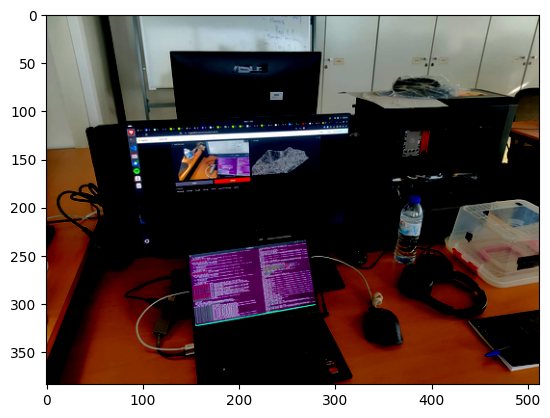

In [ ]:
from mast3r.utils.misc import mkdir_for, hash_md5
import tqdm
import matplotlib.pyplot as plt
from dust3r.post_process import estimate_focal_knowing_depth

# just forward mast3r and see what are the outputs
for img1, img2 in pairs:
    desc_conf = "desc_conf"
    idx1 = hash_md5(img1['instance'])
    idx2 = hash_md5(img2['instance'])

    path1 = cache_dir + f'/forward/{idx1}/{idx2}.pth'
    path2 = cache_dir + f'/forward/{idx2}/{idx1}.pth'
    path_corres = cache_dir + f'/corres_conf={desc_conf}_subsample={8}/{idx1}-{idx2}.pth'
    path_corres2 = cache_dir + f'/corres_conf={desc_conf}_subsample={8}/{idx2}-{idx1}.pth'

    print(path1)

    X11, C11, X21, C21 = torch.load(os.path.join(mkdir_for(path1)), weights_only=True)
    X22, C22, X12, C12 = torch.load(os.path.join(mkdir_for(path2)), weights_only=True)
    corres = torch.load(mkdir_for(path_corres), weights_only=True)

    X11, X21 = to_numpy(X11), to_numpy(X21)

    H, W = img1["img"].shape[:2]
    #print(X11.shape)
    #f11 = estimate_focal_knowing_depth(X11, torch.tensor( [W/2, H/2] ))

    break


# see correspondences
if 0:
    xy1 = (corres[1])[0].cpu().numpy()
    im = np.ones((512, 512, 3))
    plt.imshow(im)
    plt.scatter(xy1[:, 0], xy1[:, 1])
else:
    #imshow image in torch tensor
    plt.imshow(img1["img"][0,:,:,:].permute(1,2,0).cpu().numpy())


# just check what is the output of just one pair

In [ ]:
from pypcd4 import PointCloud

X11_list = X11.reshape(-1, 3).shape
X21_list = X21.reshape(-1, 3).shape

rgb_data1 = (img1["img"][0,:,:,:].permute(1,2,0).cpu().numpy().reshape(-1, 3) + 1) / 2 * np.array([0,1,0])
rgb_data2 = (img2["img"][0,:,:,:].permute(1,2,0).cpu().numpy().reshape(-1, 3) + 1) / 2 * np.array([1,0,0])

cat_pc = np.concatenate([X11.reshape(-1, 3), X21.reshape(-1, 3)], axis=0)
cat_clr = np.concatenate([rgb_data1, rgb_data2], axis=0)
print(cat_clr)

rgb_unit8 = np.array([PointCloud.encode_rgb(np.array(cat_clr * 255).astype(np.uint8))]).T

pc = PointCloud.from_xyzrgb_points(np.hstack((cat_pc, rgb_unit8)))
pc.save(outdir + '/scene.pcd')

[[0.         0.6156863  0.        ]
 [0.         0.6156863  0.        ]
 [0.         0.61960787 0.        ]
 ...
 [0.65098041 0.         0.        ]
 [0.64705884 0.         0.        ]
 [0.65098041 0.         0.        ]]


In [ ]:
torch.stack( [torch.tensor(img["true_shape"]).squeeze() for img in imgs] ).shape

torch.Size([13, 2])

### Non symmetric inference, just one branch of the network without the cross-attention

In [23]:
import matplotlib.pyplot as plt
from pypcd4 import PointCloud
from auxiliar.motion_mask import find_mask

# load co-tracker model
cotracker = torch.hub.load("facebookresearch/co-tracker", "cotracker3_offline").to(device)

# encode just one image
with torch.no_grad():
    f1, pos1, _ = model._encode_image(imgs[1]["img"].to(device),
                                       torch.from_numpy(imgs[1]["true_shape"]).to(device)) # encode just one branch of the pipeline

    dec1, _ = model._decoder(f1, pos1) # we ignore the second branch

    mask_out = find_mask(cotracker, device, imgs[0], imgs[1]) # image , height x width
    res1 = model._downstream_head(1, [tok.float() for tok in dec1],
                                torch.from_numpy(imgs[1]["true_shape"]).to(device))
    
    #print(res1["pts3d"].squeeze().cpu().numpy().shape)
    #print(mask_out.repeat.shape)

    mask_out_conf = torch.from_numpy(np.expand_dims(mask_out,axis =0)).to(torch.bool)
    mask_out_3d = torch.from_numpy(np.repeat(np.expand_dims(np.expand_dims(mask_out,axis=2),axis =0),3,axis=3)).to(torch.bool)

    res1["conf"][mask_out_conf] = 1.0
    res1["pts3d"][~mask_out_3d] = 0.0
    
    #print(new_pc.shape)
    #plt.imshow(mask_out)

    pc = PointCloud.from_xyz_points(res1["pts3d"].cpu().numpy().reshape(-1, 3))
    pc.save(outdir + '/scene.pcd')


Using cache found in /home/manuelf/.cache/torch/hub/facebookresearch_co-tracker_main


In [ ]:
from dust3r.post_process import estimate_focal_knowing_depth  # noqa

H, W = torch.tensor(imgs[0]["img"].shape[2:] )

estimate_focal_knowing_depth(res1["pts3d"], torch.tensor([W / 2, H / 2]).to(device), focal_mode='weiszfeld')

tensor([333.8799], device='cuda:1')

In [ ]:
#H, W = torch.tensor(imgs[0]["img"].shape[2:] )

torch.stack( [torch.tensor(img["true_shape"]).squeeze() for img in imgs] )


tensor([[288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512],
        [288, 512]], dtype=torch.int32)

In [ ]:
res1["conf"].shape

# change values in res1["conf"] with data from mask_out
mask_out_torch = torch.from_numpy(np.expand_dims(mask_out,axis =0)).to(torch.bool)

res1["conf"][mask_out_torch] = 1.0

#torch.min(res1["conf"])
res1["pts3d"][torch.from_numpy(np.repeat(np.expand_dims(np.expand_dims(mask_out,axis=2),axis =0),3,axis=3)).to(torch.bool)].shape
#res1["conf"]

torch.Size([353220])

In [ ]:
im0 = imgs[0]["img"]
im1 = imgs[0]["img"]


im0.shape
cat = torch.concat([im0, im1], dim=0)

# add another dimensionm
cat = cat.unsqueeze(0)
cat.shape

torch.Size([1, 2, 3, 288, 512])

In [ ]:
imgs[0]["img"].shape[2]

288